# Analyzing Biodiversity Intactness Index change in Phoenix, Arizona
### EDS 220 Final Project
##### Author: Ava Robillard
##### GitHub repository: https://github.com/avarobillard/phoenix-biodiversity

### Purpose:
The Phoenix metropolitan area, located in Maricopa County, experienced significant increases in urban sprawl between the years of 2017 and 2020. This analysis serves to understand the implications for biodiveristy and the health of surrounding ecosystems using the change in Biodiversity Intactness Index between that time period.

### Analysis highlights:

- Geospatial data exploration and wrangling with `geopandas`
- Accessing data using a STAC (SpatioTemporal Asset Catalog) API
- NetCDF data exploration and wrangling with `xarray` and `rioxarray`
- Mapping of vector and raster data and customization with `matplotlib`

### About the data:

In this notebook we use two datasets:

1) The data used for the geographic extent of the Phoenix area was the Phoenix Subdivision polygon, retrieved from the TIGER/Line Census County Subdivision shapefiles for Arizona available through the [U.S Census Bureau's data catalog](https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision). The data is able to be filtered and includes names of county subdivisions, such as Phoenix, as well as county FIPS codes, such as for Maricopa County.

2) The Biodiversity Intactness Index (BII) Time Series used for this analysis is retrieved from the  io-biodiversity collection from the [Microsoft Planetary Computer STAC catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). The rasters contain 100-meter resolution estimates of biodiversity intactness, which is estimated from two metrics: Abundance and Compositional Similarity of species. BII is on a 0-1 scale. We will specifically be searching the catalog for rasters from 2017 and 2020 covering the Pheonix subdivision. 

### References 

U.S. Census Bureau, Geography Division. (2024). TIGER/Line shapefile, current, state, Arizona, county subdivision (Publication year 2024; created 2024-10; updated 2024-10) [Data set]. U.S. Department of Commerce. Accessed December 5, 2025, from https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision

Impact Observatory. (2017-2020). Biodiversity Inactness[io-biodiversity]. Microsoft Planetary Computer STAC catalog. Accessed December 5, 2025, from https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview 







In [249]:
# Load packages
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rioxr
import contextily as ctx
import matplotlib.patches as mpatches

from pystac_client import Client # to access STAC catalogs
import planetary_computer # to sign items from the MPC STAC catalog
from IPython.display import Image # to nicely display image

### 1. Import and explore Phoenix Subdivision Shapefile

First, we want to import our TIGER shapefiles for Arizona and do some intial data exploration.

In [2]:
# Import Phoenix Subdivision Shapefile
fp = os.path.join('data', 'tl_2024_04_cousub', 'tl_2024_04_cousub.shp')
az = gpd.read_file(fp)

In [3]:
# Display first few rows of Arizona GeoDataFrame
az.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12231962349,44576380,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228864156,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,0600000US0402392295,Nogales,Nogales CCD,22,Z5,G4040,S,1762339489,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,0600000US0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,S,1439560139,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


In [4]:
# Check the CRS
print(az.crs)

EPSG:4269


In [5]:
# Examine CRS details
print('Ellipsoid:', az.crs.ellipsoid)
print('Datum:', az.crs.datum)
print('Is geographic?:', az.crs.is_geographic)
print('Is projected?:', az.crs.is_projected)

Ellipsoid: GRS 1980
Datum: North American Datum 1983
Is geographic?: True
Is projected?: False


In [6]:
# Print unique county codes
az['COUNTYFP'].unique()

array(['005', '023', '011', '013', '019', '017', '015', '007', '003',
       '025', '021', '001', '027', '009', '012'], dtype=object)

In [7]:
# Print unique county subdivsion names 
az['NAME'].unique()

array(['Flagstaff', 'Kaibab Plateau', 'Hualapai', 'Nogales', 'Patagonia',
       'Hopi', 'Tuba City', 'Clifton', 'Duncan', 'Chandler', 'Phoenix',
       'Tonto National Forest', 'Gila Bend', 'Wickenburg', 'Deer Valley',
       'Buckeye', 'St. Johns', 'Salt River', 'Tucson', 'Arivaca',
       'Indian Wells', 'Winslow-Holbrook', 'Snowflake', 'Kayenta',
       'Lake Havasu City', 'Fort Apache', 'Bisbee', 'Bowie', 'Willcox',
       'North Mohave', 'Kingman', 'Bullhead City', 'Congress',
       'Mingus Mountain', 'Florence', 'North Pinal', 'San Manuel', 'Eloy',
       'Chinle', 'Sweetwater', 'Fort Defiance', 'Dennehotso', 'Puerco',
       'Ash Fork', 'Cordes Lakes-Mayer', 'Camp Verde-Sedona', 'Prescott',
       'Piñon', 'Payson', 'Winkelman', 'Globe-Miami', 'Tonto Basin',
       'Gila River', 'Casa Grande', 'Maricopa-Stanfield',
       "Tohono O'odham Nation", 'Coolidge', 'Ajo', 'Marana', 'Somerton',
       'Bonita-Klondyke', 'Eagar-Springerville', 'San Carlos',
       'Havasupai', 'William

First, we see that the Coordinate Reference System (CRS) for this data is EPSG: 4269. This is a geographic coordinate system and uses degrees for locations, so we will likely need to change this to a projected coordinate system for mapping. The `COUNTYFP` column contains the FIPS codes for each county in Arizona. Maricopa county's [FIPS code](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) is 013. The `NAME` column contains county subdivision names, including Phoenix which we will need to filter to for our desired spatial extent.

In [216]:
# Convert to projected CRS for plotting
az = az.to_crs(epsg=3857)

In [ ]:
# Use the 'COUNTYFP' column to filter to Maricopa County 
maricopa = az[az['COUNTYFP'] == '013']

# Use the 'NAME' column to filter to the Phoenix subdivision
phoenix = maricopa[maricopa['NAME'] == "Phoenix"]

Now that we have filtered our data, we can make a few plots to visualize the spatial extent of Phoenix as well as it's geographic context within Maricopa County and the state of Arizona.

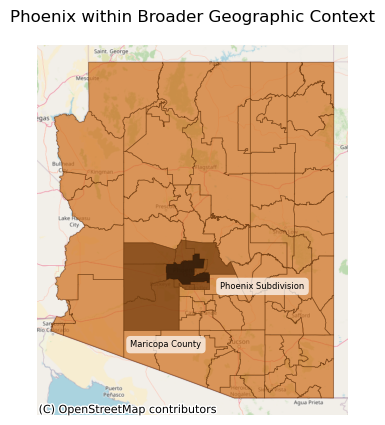

In [ ]:
# Plot Phoenix in geographic context
fig, ax = plt.subplots()

az.plot(ax=ax,
             alpha=0.7,
             color='#CF6E1B',
             edgecolor = "#6E3C12",
             linewidth = 0.5)

maricopa.plot(ax=ax,
             alpha=0.7,
             color='#703A0C',
             linewidth = 3)

phoenix.plot(ax=ax,
             alpha=0.7,
             color='#1A0D03',
             linewidth = 3)

# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs = az.crs)

# Add county label (Maricopa)
ax.text(maricopa.geometry.centroid.iloc[0].x - 80000,
        maricopa.geometry.centroid.iloc[0].y - 140000,
        "Maricopa County",
        color="black",
        fontsize=6,
        ha='center',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5, boxstyle="round"))

# Add subdivision label (Phoenix)
ax.text(phoenix.geometry.centroid.iloc[0].x + 170000,
        phoenix.geometry.centroid.iloc[0].y - 40000,
        "Phoenix Subdivision",
        color="black",
        fontsize=6,
        ha='center',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5, boxstyle="round"))


ax.axis('off')

# Add title
plt.title('Phoenix within Broader Geographic Context')

plt.show()

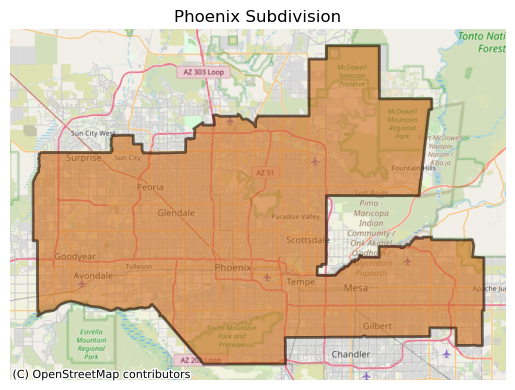

In [ ]:
# Plot Phoenix individually
fig, ax = plt.subplots()
phoenix.plot(ax=ax,
             alpha=0.6,
             color='#CF6E1B',
             edgecolor = '#1A0D03',
             linewidth = 2)

# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs = az.crs)

ax.axis('off')

plt.title("Phoenix Subdivision")

plt.show()

### 2. Access and explore Biodiversity Intactness Index

Next, we will explore our second data set. The Biodiversity Intactness Index is located within the io-biodiversity collection, which can be accessed from the Microsoft Planetary Computer STAC catalog. Each collection within the catalog has multiple items, which have properties (metadata) and assests (links to the data). Because we need the BII of the Phoenix area specifically during the years of 2017 and 2020, we will need to search the io-biodiversity collection using a specifc time range and bounding box.

In [197]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

We can use the Biodiversity Intactness catalog's ID `io-biodiversity` to select it, as well as a specified bounding box and time range. Our goal is to narrow down the catalog search for Biodiversity Intactness scenes over Phoenix from 2017 to 2020. 

In [269]:
# Phoenix bounding box 
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Temporal range of interest
time_range = "2017-01-01/2020-01-01"

# Catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_range
)

In [276]:
# Check how many items are in search results
items = search.item_collection()
len(items)

4

These are the four years of data we requested, 2017-2020.

In [275]:
# Check dates of items
print(f"The start date of item 0 is {items[0].properties.get('start_datetime')}")
print(f"The start date of item 3 is {items[3].properties.get('start_datetime')}")

The start date of item 0 is 2020-01-01T00:00:00Z
The start date of item 3 is 2017-01-01T00:00:00Z


In [ ]:
# Save the first item in the catalog search for 2020
item2020 = items[0]

# Save the third item in the catalog search for 2017
item2017 = items[3]

In [203]:
# Examine more information about each asset in the item
for key in item2017.assets.keys():
    print(key, '--', item2017.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


Each of these assests has an `href`, or a link to the data. We want to use this to access the data asset within each item using `rioxr.open_rasterio`. Because the `band` dimension had a length of 1, we can use `.squeeze()` to drop it, producing a DataArray with just the spatial dimensions (y, x) for easier analysis.

In [306]:
# Open 2017 BII over Phoenix
bii2017 = rioxr.open_rasterio(item2017.assets['data'].href).squeeze().drop_vars('band')
bii2017

print(f"The data type of bii2017 is {type(bii2017)}")

The data type of bii2017 is <class 'xarray.core.dataarray.DataArray'>


In [ ]:
# Open 2020 BII over Phoenix
bii2020 = rioxr.open_rasterio(item2020.assets['data'].href).squeeze().drop_vars('band')
bii2020

<class 'xarray.core.dataarray.DataArray'>


### 3. Combine Phoenix and Biodiversity Intactness data

Now that we have accessed our data, we need to ensure that the the CRSs of the Biodiversity Intactness raster and Phoenix Subdivision polygon are the same.

In [237]:
# Match CRSs and verify update 
phoenix = phoenix.to_crs(bii2017.rio.crs)
assert phoenix.crs == bii2017.rio.crs
assert phoenix.crs == bii2020.rio.crs

Next, we need to clip the data to the same extent as our Phoenix polygon. We do this in two steps to make the operation less costly, first by using `rio.clip_box()` to clip the raster to an initial box around Phoenix, and then using `rio.clip()` to perform the more detailed clipping to the actual Phoenix perimeter.

In [ ]:
# Clip each year to Phoenix boundary
bii2017_clip = (bii2017.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry))
bii2020_clip = (bii2020.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry))

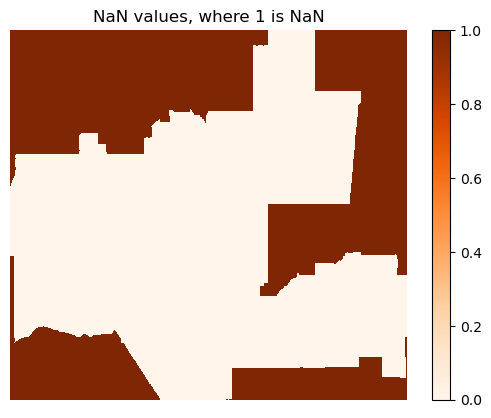

In [314]:
# Plot NaN values after clipping
fig, ax = plt.subplots()
bii2017_clip.isnull().plot(ax=ax,
                           cmap = 'Oranges')

ax.axis('off')

plt.title("NaN values, where 1 is NaN")

plt.show()

We can see that the clipping used NaN values to mask the area outside of our area of interest. because so many pixels will be null, we will need to ensure we are using the correct methods when counting pixel values in our rasters.

### 4. Calculate BII differences

Next, we want to calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 and 2020. This will allow us to identify areas that had a high BII value in 2017 but not 2020. 

Our first step is to create new rasters containing booleans (`TRUE/FALSE`) for whether the cell had a BII value of at least 0.75. 

We can use the sum of the TRUE cells in this raster (`TRUE` values are 1) divided by the total count of cells in our original raster to get the proportion of cells with BII values of at least 0.75. We use `count()` because this counts only the valid (non-NaN) pixels.

We then multiply this value by 100 to get a percent.

In [308]:
# Create rasters of area where BII is at least 0.75
# 2017
bii2017_75 = bii2017_clip >= 0.75

# 2020
bii2020_75 = bii2020_clip >= 0.75

# Calcualte percentage of area 
biipercent_2017 = (bii2017_75.sum()/bii2017_clip.count()) * 100
biipercent_2020 = (bii2020_75.sum()/bii2020_clip.count()) * 100

print(f"In 2017, {biipercent_2017:.2f}% of the Phoenix Subdivison had a BII of at least 0.75")
print(f"In 2020, {biipercent_2020:.2f}% of the Phoenix Subdivison had a BII of at least 0.75")

In 2017, 7.13% of the Phoenix Subdivison had a BII of at least 0.75
In 2020, 6.49% of the Phoenix Subdivison had a BII of at least 0.75


Next, we need to find the pixels with a BII of at least 0.75 in 2017 (`TRUE`) that were no longer above this threshold in 2020 (`FALSE`). 

To do this, we can use a logical operation where we want the specific combination of pixels classified as `TRUE` in 2017 and `FALSE` in 2020. This creates a raster of `TRUE` where there was a BII loss between the years. 

Lastly, we want to replace any areas where this loss raster was `FALSE` with nan values for plotting.

In [283]:
# Find pixels that changed value between 2017 and 2020
bii_loss = (bii2017_75 == True) & (bii2020_75 == False)

# Keep only pixels with loss
bii_loss = bii_loss.where(bii_loss, np.nan)

### 5. Visualize BII difference

We will use `matplotlib` to create a visualization of the Biodiversity Intactness Index loss between 2017 and 2020.

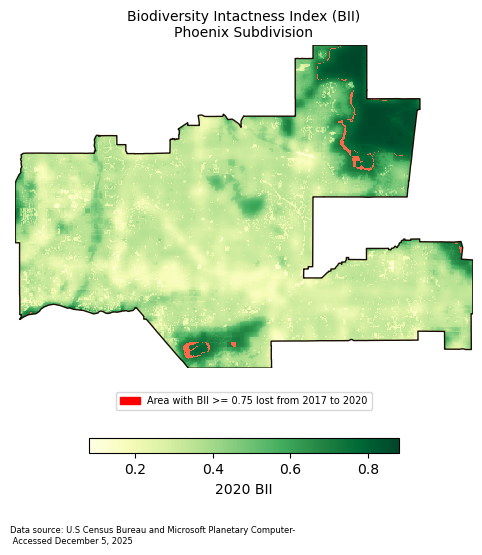

In [322]:
# Plot BII change
fig, ax = plt.subplots(figsize=(8,6))

bii2020_clip.plot(ax = ax,
                  cmap = "YlGn",
                  cbar_kwargs = {'location':'bottom',
                                  'label':'2020 BII',
                                  'shrink':0.5})

bii_loss.plot(ax = ax,
              cmap = "Reds",
              add_colorbar = False)

phoenix.plot(ax = ax, 
             color = 'none',
             edgecolor = '#1A0D03')

# Add legend for loss instead of cmap- the value is just 1
loss_patch = mpatches.Patch(color = 'red',
                            label = 'Area with BII >= 0.75 lost from 2017 to 2020')

ax.legend(handles = [loss_patch],
           loc = 'center',
           bbox_to_anchor = (0.5, -0.1),
           fontsize = 7)

ax.axis('off')

plt.title('Biodiversity Intactness Index (BII)\nPhoenix Subdivision', size = 10)

plt.figtext(0.22, 0.05, "Data source: U.S Census Bureau and Microsoft Planetary Computer- \n Accessed December 5, 2025", fontsize = 6)

plt.show()

## Interpretation

Based on the figure, the Biodiversity Intactness Index is below about 0.4 throughout most of the Phoenix Subdivision. There are pockets of BII values around 0.6-0.8, or areas with higher species abundance and more diverse species compostions. These areas correspond to natural areas such as the South Mountain Park and Preserve and the McDowell Preserves, which are likely to be zones where wildlife has been made to consolidate within due to surrounding urban areas. With Phoenix experiencing rapid urban sprawl, it makes sense that the areas with high BII values (>= 0.75) lost between 2017 and 2020 are largely located around the perimeters of these natural ecosystems. The intact biodiverse areas are visibly shrinking due to more human activity and developement, making them even more important to protect.